In [21]:
import os
import pickle
import copy

import torch
import torch_geometric
import numpy as np
import networkx as nx
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib import gridspec
from glycowork.glycan_data.loader import lib

from glycontact.lwca import LinearWarmupCosineAnnealingLR
from glycontact.visualize import extract_torsion_angles
from glycontact.learning import GINSweetNet, VonMisesSweetNet, create_dataset, train_model, clean_split, build_baselines, evaluate_model, angular_rmse, value_rmse

# Seed everything for reproducibility
torch_geometric.seed_everything(42)

## Data Preprocessing

In [22]:
if not os.path.exists("conformer_split.pkl"):
    multi_train, multi_test = create_dataset()
    with open("conformer_split.pkl", "wb") as f:
        pickle.dump((multi_train, multi_test), f)
else:
    with open("conformer_split.pkl", "rb") as f:
        multi_train, multi_test = pickle.load(f)

# clean_test = clean_split(test, mode="mean")
train = clean_split(multi_train, mode="max")
test = clean_split(multi_test, mode="max")

## Model Training

#### Single Conformer

In [23]:
# Monomer baselines
mean_phi_predictor, mean_psi_predictor, mean_sasa_predictor, mean_flex_predictor = build_baselines([d[1] for d in train], np.mean)
median_phi_predictor, median_psi_predictor, median_sasa_predictor, median_flex_predictor = build_baselines([d[1] for d in train], np.median)

In [24]:
model = GINSweetNet(len(lib), num_classes=4, hidden_dim=256).to("cuda")
optim = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = LinearWarmupCosineAnnealingLR(optimizer=optim, warmup_epochs=25, max_epochs=50, warmup_start_lr=1e-5, eta_min=1e-7)
metrics, model = train_model(
    model,
    {
        "train": torch_geometric.loader.DataLoader([x[0] for x in train], batch_size=64, shuffle=True),
        "val": torch_geometric.loader.DataLoader([x[0] for x in test], batch_size=64),
    },
    optim,
    scheduler,
    num_epochs=150,
)

Epoch 0/149
----------
train Loss: 10.8616 Phi: 1.5134 Psi: 2.9502 SASA: 223.8793 Flex: 2.6667 LR: 0.0000
val Loss: 11.1676 Phi: 1.5182 Psi: 2.9838 SASA: 221.7686 Flex: 2.9695 LR: 0.0000

Epoch 1/149
----------
train Loss: 10.8268 Phi: 1.5129 Psi: 2.9507 SASA: 224.0791 Flex: 2.6285 LR: 0.0001
val Loss: 11.1598 Phi: 1.5184 Psi: 2.9839 SASA: 221.7153 Flex: 2.9622 LR: 0.0001

Epoch 2/149
----------
train Loss: 10.8141 Phi: 1.5114 Psi: 2.9476 SASA: 224.0733 Flex: 2.6205 LR: 0.0001
val Loss: 11.0867 Phi: 1.5181 Psi: 2.9834 SASA: 221.6754 Flex: 2.8906 LR: 0.0001

Epoch 3/149
----------
train Loss: 10.7058 Phi: 1.5112 Psi: 2.9475 SASA: 224.0328 Flex: 2.5132 LR: 0.0001
val Loss: 10.9856 Phi: 1.5168 Psi: 2.9824 SASA: 221.6341 Flex: 2.7924 LR: 0.0001

Epoch 4/149
----------
train Loss: 10.6838 Phi: 1.5106 Psi: 2.9493 SASA: 223.8372 Flex: 2.4932 LR: 0.0002
val Loss: 10.9077 Phi: 1.5153 Psi: 2.9812 SASA: 221.5914 Flex: 2.7180 LR: 0.0002

Epoch 5/149
----------
train Loss: 10.6195 Phi: 1.5090 Psi: 

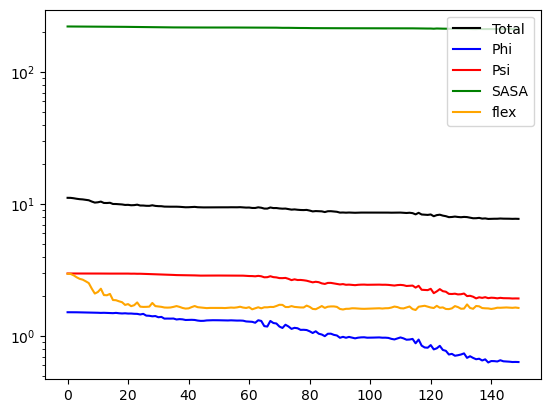

In [25]:
plt.plot(metrics["val"]["loss"], c="black", label="Total")
plt.plot(metrics["val"]["phi_loss"], c="blue", label="Phi")
plt.plot(metrics["val"]["psi_loss"], c="red", label="Psi")
plt.plot(metrics["val"]["sasa_loss"], c="green", label="SASA")
plt.plot(metrics["val"]["flex_loss"], c="orange", label="flex")

plt.yscale("log")
plt.legend()

plt.show()

In [26]:
print("Mean:\n\t", evaluate_model((mean_phi_predictor, mean_psi_predictor, mean_sasa_predictor, mean_flex_predictor), multi_test)[:4])
print("Median:\n\t", evaluate_model((median_phi_predictor, median_psi_predictor, median_sasa_predictor, median_flex_predictor), multi_test)[:4])
m_psi, m_phi, m_sasa, m_flex, m_pred = evaluate_model(model, multi_test)
print("GINSweetNet:\n\t", m_psi, m_phi, m_sasa, m_flex)

tensor(0.6106, dtype=torch.float64) tensor(1.1522, dtype=torch.float64)
Mean:
	 (34.986221386756135, 66.01564344415988, 47.2502914099113, 1.8377546589091898)
tensor(0.5970, dtype=torch.float64) tensor(0.8717, dtype=torch.float64)
Median:
	 (34.206624744671196, 49.944984684190906, 48.18142122376384, 1.9506542911616842)
1143 / 1143
tensor(0.8074) tensor(1.3853)
GINSweetNet:
	 46.25908173893382 79.37265162766687 211.28316395562953 1.6574230775515437


#### Multi-Conformer

In [27]:
# Monomer baselines
multi_mean_phi_predictor, multi_mean_psi_predictor, multi_mean_sasa_predictor, multi_mean_flex_predictor = build_baselines([d[1] for d in multi_train], np.mean)
multi_median_phi_predictor, multi_median_psi_predictor, multi_median_sasa_predictor, multi_median_flex_predictor = build_baselines([d[1] for d in multi_train], np.median)

In [28]:
multi_model = VonMisesSweetNet(len(lib), num_classes=4, hidden_dim=256).to("cuda")
multi_optim = torch.optim.Adam(multi_model.parameters(), lr=0.001)
# multi_scheduler = LinearWarmupCosineAnnealingLR(optimizer=multi_optim, warmup_epochs=25, max_epochs=50, warmup_start_lr=1e-5, eta_min=1e-7)
multi_metrics, multi_model = train_model(
    multi_model,
    {
        "train": torch_geometric.loader.DataLoader([x[0] for x in multi_train], batch_size=64, shuffle=True),
        "val": torch_geometric.loader.DataLoader([x[0] for x in multi_test], batch_size=64),
    },
    multi_optim,
    None,  # multi_scheduler,
    num_epochs=150,
)

Epoch 0/149
----------
train Loss: 7.6885 Phi: 1.0365 Psi: 1.2723 SASA: 223.0577 Flex: 1.6621 LR: 0.0010
val Loss: 6.9618 Phi: 0.6498 Psi: 0.9585 SASA: 221.0125 Flex: 1.6700 LR: 0.0010

Epoch 1/149
----------
train Loss: 6.4534 Phi: 0.5326 Psi: 0.9602 SASA: 221.4337 Flex: 1.2701 LR: 0.0010
val Loss: 6.6967 Phi: 0.5469 Psi: 0.8609 SASA: 219.4019 Flex: 1.6322 LR: 0.0010

Epoch 2/149
----------
train Loss: 6.1707 Phi: 0.3923 Psi: 0.8759 SASA: 219.5348 Flex: 1.2435 LR: 0.0010
val Loss: 6.5037 Phi: 0.3887 Psi: 0.8422 SASA: 217.2858 Flex: 1.6514 LR: 0.0010

Epoch 3/149
----------
train Loss: 5.9909 Phi: 0.3292 Psi: 0.8264 SASA: 217.2586 Flex: 1.2144 LR: 0.0010
val Loss: 6.4842 Phi: 0.3717 Psi: 0.8863 SASA: 214.6776 Flex: 1.6482 LR: 0.0010

Epoch 4/149
----------
train Loss: 5.8838 Phi: 0.2885 Psi: 0.8092 SASA: 214.3936 Flex: 1.2129 LR: 0.0010
val Loss: 6.1734 Phi: 0.3194 Psi: 0.7850 SASA: 211.2268 Flex: 1.5486 LR: 0.0010

Epoch 5/149
----------
train Loss: 5.7409 Phi: 0.2590 Psi: 0.7913 SASA

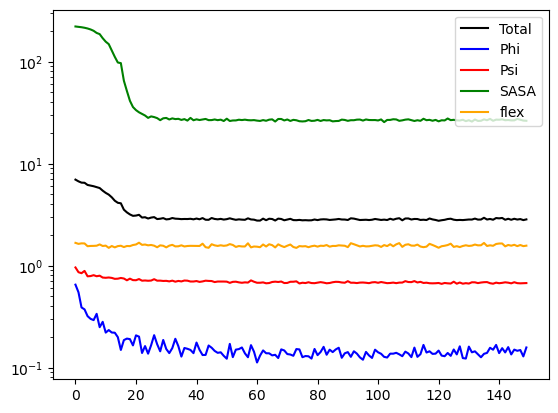

In [29]:
plt.plot(multi_metrics["val"]["loss"], c="black", label="Total")
plt.plot(multi_metrics["val"]["phi_loss"], c="blue", label="Phi")
plt.plot(multi_metrics["val"]["psi_loss"], c="red", label="Psi")
plt.plot(multi_metrics["val"]["sasa_loss"], c="green", label="SASA")
plt.plot(multi_metrics["val"]["flex_loss"], c="orange", label="flex")

plt.yscale("log")
plt.legend()

plt.show()

In [30]:
print("Mean:\n\t", evaluate_model((multi_mean_phi_predictor, multi_mean_psi_predictor, multi_mean_sasa_predictor, multi_mean_flex_predictor), multi_test)[:4])
print("Median:\n\t", evaluate_model((multi_median_phi_predictor, multi_median_psi_predictor, multi_median_sasa_predictor, multi_median_flex_predictor), multi_test)[:4])
mm_psi, mm_phi, mm_sasa, mm_flex, mm_pred = evaluate_model(multi_model, multi_test)
print("VonMisesSweetNet:\n\t", mm_psi, mm_phi, mm_sasa, mm_flex)
print("(Phi RMSE, PSI RMSE, SASA RMSE, Flexibility RMSE)")

tensor(0.6045, dtype=torch.float64) tensor(1.1398, dtype=torch.float64)
Mean:
	 (34.637671810288815, 65.30569956183365, 47.47243275981165, 1.8463894234697955)
tensor(0.6101, dtype=torch.float64) tensor(0.8657, dtype=torch.float64)
Median:
	 (34.957870922892084, 49.60165202409293, 48.6334846606489, 1.942044404095067)
1143 / 1143
tensor(0.5408) tensor(0.7873)
VonMisesSweetNet:
	 30.986570434015622 45.10857052419102 27.133103311698985 1.6166605603331359
(Phi RMSE, PSI RMSE, SASA RMSE, Flexibility RMSE)


## Visulaze Multi-Conformer VonMisesSweetNet

In [31]:
def ramachandran_plot(
        disaccharide: str, 
        structure_graphs: list[nx.DiGraph],
        density: bool = True,
        ax: plt.Axes = None,
        mode: str = None,
        split: str = None,
        conf: str = None,
) -> plt.Figure:
    """Generate a Ramachandran plot for a specific disaccharide linkage.
    Args:
    disaccharide: String representing the disaccharide (e.g., "Fuc(a1-2)Gal")
    structure_graphs: Dictionary of glycan structure graphs
    density: Whether to show density contours (default: True)
    filepath: Path to save the figure (optional)
    Returns:
    Matplotlib figure object
    """
    phi_angles, psi_angles = extract_torsion_angles(disaccharide, dict(enumerate(structure_graphs)))
    if not phi_angles or not psi_angles:
        raise ValueError(f"No torsion angles found for disaccharide: {disaccharide}")
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))
    
    # Create density contours if requested
    if density and len(phi_angles) > 3:
        # Calculate the point density
        xy = np.vstack([phi_angles, psi_angles])
        z = stats.gaussian_kde(xy)(xy)
        # Sort the points by density for better visualization
        idx = z.argsort()
        x_sorted, y_sorted, z_sorted = np.array(phi_angles)[idx], np.array(psi_angles)[idx], z[idx]
        # Clear the previous plot and redraw with density coloring
        ax.clear()
        scatter = ax.scatter(x_sorted, y_sorted, c=z_sorted, s=30, cmap='viridis')
        plt.colorbar(scatter, ax=ax, label='Density')
    else:
        # Create the scatter plot
        ax.scatter(phi_angles, psi_angles, alpha=0.7, s=30, c='blue', edgecolor='white')

    # Set plot limits and labels
    ax.set_xlim(-180, 180)
    ax.set_ylim(-180, 180)
    ax.set_xlabel('Phi (°)')
    ax.set_ylabel('Psi (°)')
    ax.set_title(f'Ramachandran Plot for {(mode + " ") if mode else ""}{disaccharide} angles{(" in " + split) if split else ""} {conf} conformers')
    # Add grid lines
    ax.grid(alpha=0.3)
    # Add the origin lines
    ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)
    ax.axvline(x=0, color='k', linestyle='--', alpha=0.3)
    # Add statistics
    stats_text = (
        f"n = {len(phi_angles)}\n"
        f"Mean φ = {np.mean(phi_angles):.1f}° ± {np.std(phi_angles):.1f}°\n"
        f"Mean ψ = {np.mean(psi_angles):.1f}° ± {np.std(psi_angles):.1f}°"
    )
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

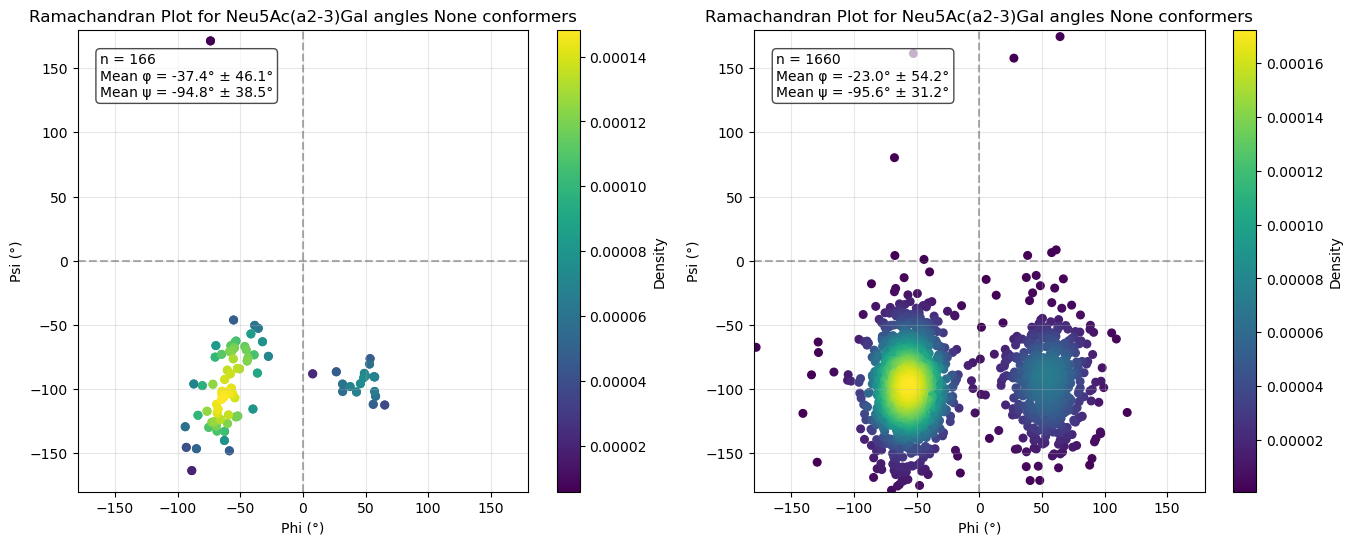

In [32]:
fig = plt.figure(figsize=(16, 6))
gs = gridspec.GridSpec(1, 2, figure=fig)
axs = [fig.add_subplot(gs[0]), fig.add_subplot(gs[1])]
ramachandran_plot(disaccharide="Neu5Ac(a2-3)Gal", structure_graphs=[x[1] for x in multi_test], density=True, ax=axs[0])
ramachandran_plot(disaccharide="Neu5Ac(a2-3)Gal", structure_graphs=mm_pred, density=True, ax=axs[1])
# plt.savefig("ramachandran_Neu5Ac_a23_Gal.pdf", dpi=300, bbox_inches='tight')

The same plot with the GINSweetNet, highlighting the difference in generative power.

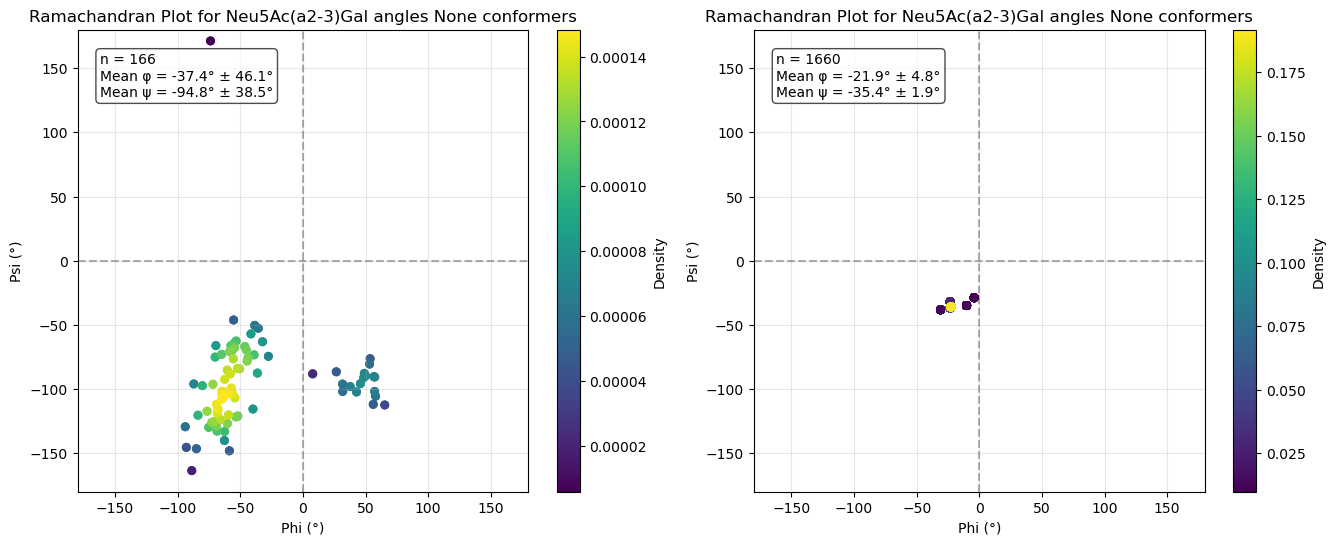

In [33]:
fig = plt.figure(figsize=(16, 6))
gs = gridspec.GridSpec(1, 2, figure=fig)
axs = [fig.add_subplot(gs[0]), fig.add_subplot(gs[1])]
ramachandran_plot(disaccharide="Neu5Ac(a2-3)Gal", structure_graphs=[x[1] for x in multi_test], density=True, ax=axs[0])
ramachandran_plot(disaccharide="Neu5Ac(a2-3)Gal", structure_graphs=m_pred, density=True, ax=axs[1])
# plt.savefig("ramachandran_Neu5Ac_a23_Gal.pdf", dpi=300, bbox_inches='tight')

A OOD plot with the VonMisesSweetNet. Rha(a1-3)GalNAc is not contained in the training data.

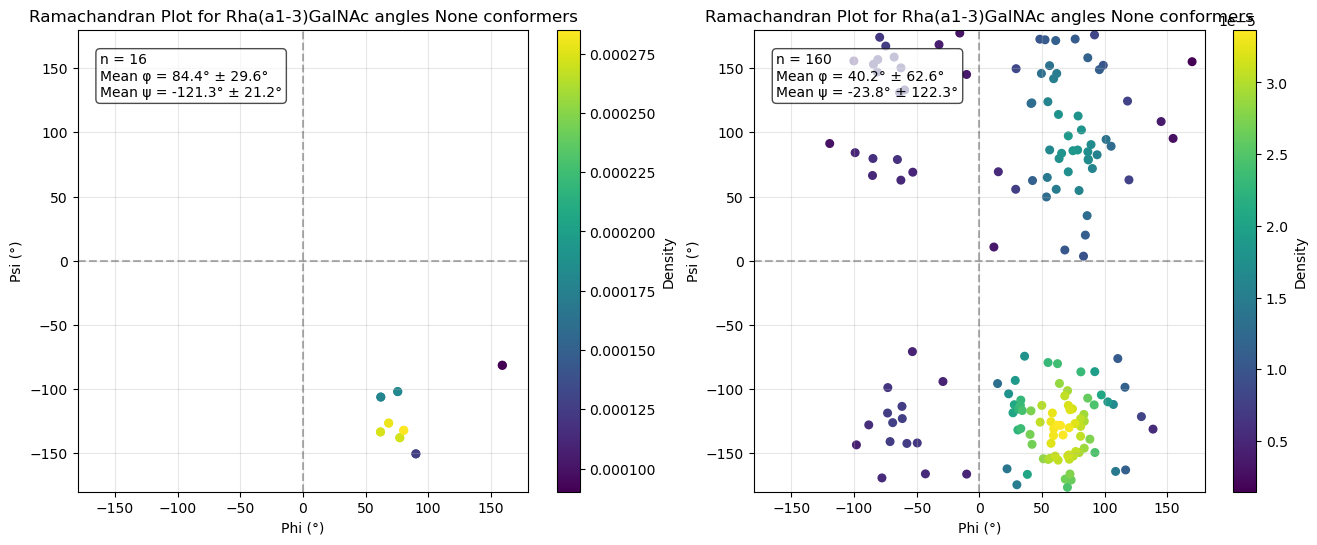

In [34]:
fig = plt.figure(figsize=(16, 6))
gs = gridspec.GridSpec(1, 2, figure=fig)
axs = [fig.add_subplot(gs[0]), fig.add_subplot(gs[1])]
ramachandran_plot(disaccharide="Rha(a1-3)GalNAc", structure_graphs=[x[1] for x in multi_test], density=True, ax=axs[0])
ramachandran_plot(disaccharide="Rha(a1-3)GalNAc", structure_graphs=mm_pred, density=True, ax=axs[1])
# plt.savefig("ramachandran_Neu5Ac_a23_Gal.pdf", dpi=300, bbox_inches='tight')

0.9150317216826859


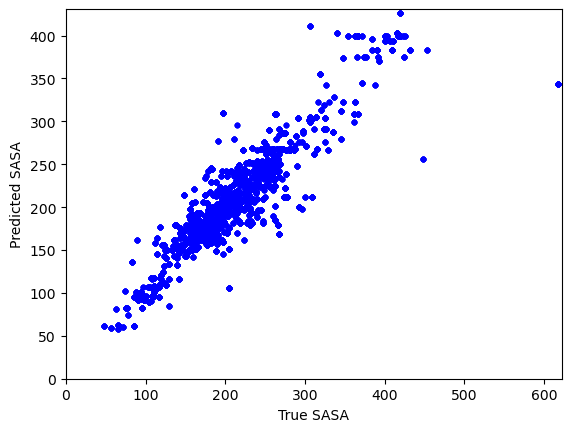

In [35]:
def plot_value_distributions(
        true_graphs: list[nx.DiGraph],
        pred_graphs: list[nx.DiGraph],
        value_name: str,
):
    true_values, pred_values = [], []
    for true_graph, pred_graph in zip(true_graphs, pred_graphs):
        for n in true_graph.nodes:
            if value_name in true_graph.nodes[n] and value_name in pred_graph.nodes[n]:
                true_values.append(true_graph.nodes[n][value_name])
                pred_values.append(pred_graph.nodes[n][value_name])
    
    plt.scatter(true_values, pred_values, s=10, marker="o", c="blue")
    print(np.corrcoef(true_values, pred_values)[0, 1])
    plt.xlim(0, min(5 + max(true_values), 1.2 * max(true_values)))
    plt.ylim(0, min(5 + max(pred_values), 1.2 * max(pred_values)))
    plt.xlabel(f"True {value_name}")
    plt.ylabel(f"Predicted {value_name}")

plot_value_distributions(
    [t[1] for t in multi_test], 
    [mm_pred[x] for x in range(0, len(mm_pred), 10)],
    value_name="SASA",
)

0.5223407442915246


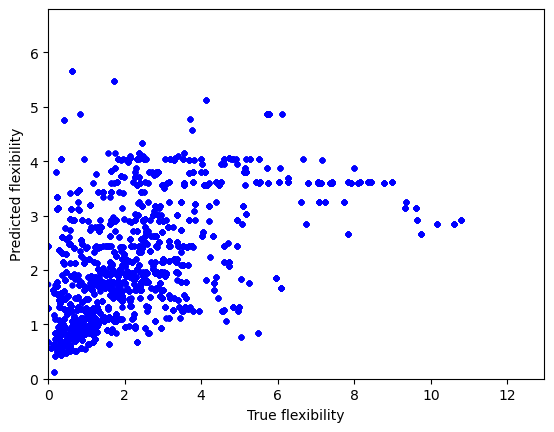

In [36]:
plot_value_distributions(
    [t[1] for t in multi_test], 
    [mm_pred[x] for x in range(0, len(mm_pred), 10)],
    value_name="flexibility",
)

## Ablation studies (unfinished!)

In [37]:
data = dict()
for t, _ in multi_test:
    if t.iupac not in data:
        data[t.iupac] = [0, t.iupac.count("(")]
    data[t.iupac][0] += 1
data = list(sorted(data.items(), key=lambda x: x[1][0] / (x[1][1] + 1e-5), reverse=True))
data[:20]

[('Fuc', [1, 0]),
 ('Glc(a1-4)Rha', [18, 1]),
 ('Man(b1-4)Gal(a1-4)Rha', [16, 2]),
 ('GlcNAc(b1-6)GlcNAc(b1-6)GlcNAc', [16, 2]),
 ('Glc(b1-4)GlcA(a1-3)Fuc', [16, 2]),
 ('Rha(a1-3)GalNAc(a1-3)GalNAc', [16, 2]),
 ('GlcNAc(b1-3)Fuc', [8, 1]),
 ('Araf(b1-2)Araf', [8, 1]),
 ('IdoA2S(a1-4)GlcNS6S', [8, 1]),
 ('GlcNAc(b1-4)GlcNAc', [8, 1]),
 ('Gal(b1-4)Glc', [8, 1]),
 ('Gal(b1-4)GlcNAc(b1-2)Man', [14, 2]),
 ('Neu5Ac(a2-6)GalNAc(a1-3)GlcNAc', [14, 2]),
 ('Rha(a1-2)Rha(a1-2)Rha', [14, 2]),
 ('Rha(a1-2)Rha(a1-3)Rha(a1-3)GlcNAc', [20, 3]),
 ('Man(a1-3)Man(a1-3)GlcNAc', [12, 2]),
 ('Gal(a1-3)Gal(a1-3)Gal', [12, 2]),
 ('Gal(b1-3)GalNAc(a1-3)GlcNAc', [12, 2]),
 ('GalNAc(b1-3)Gal(a1-3)Gal(b1-4)Glc', [16, 3]),
 ('Gal(b1-3)[Neu5Gc(a2-6)]GalNAc', [10, 2])]

In [38]:
test_spec = [i for i, t in enumerate(multi_test) if t[0].iupac == "Man(a1-3)Man(a1-3)GlcNAc"]
test_spec = test_spec[:6]
print(test_spec)
for i in test_spec:
    print(multi_test[i][0].conformer)

[170, 171, 172, 173, 174, 175]
cluster0_alpha
cluster1_alpha
cluster2_alpha
cluster3_alpha
cluster4_alpha
cluster5_alpha


In [39]:
conformer_torsion_angles = []
bond1 = extract_torsion_angles("Man(a1-3)Man", {str(i): multi_test[conformer_idx][1] for i, conformer_idx in enumerate(test_spec)})
bond2 = extract_torsion_angles("Man(a1-3)GlcNAc", {str(i): multi_test[conformer_idx][1] for i, conformer_idx in enumerate(test_spec)})
for conformer_idx in test_spec[:8]:
    b1 = extract_torsion_angles("Man(a1-3)Man", {str(i): p for i, p in enumerate(mm_pred[conformer_idx * 10 : (conformer_idx + 1) * 10])})
    b2 = extract_torsion_angles("Man(a1-3)GlcNAc", {str(i): p for i, p in enumerate(mm_pred[conformer_idx * 10 : (conformer_idx + 1) * 10])})
    conformer_torsion_angles.append((b1, b2))

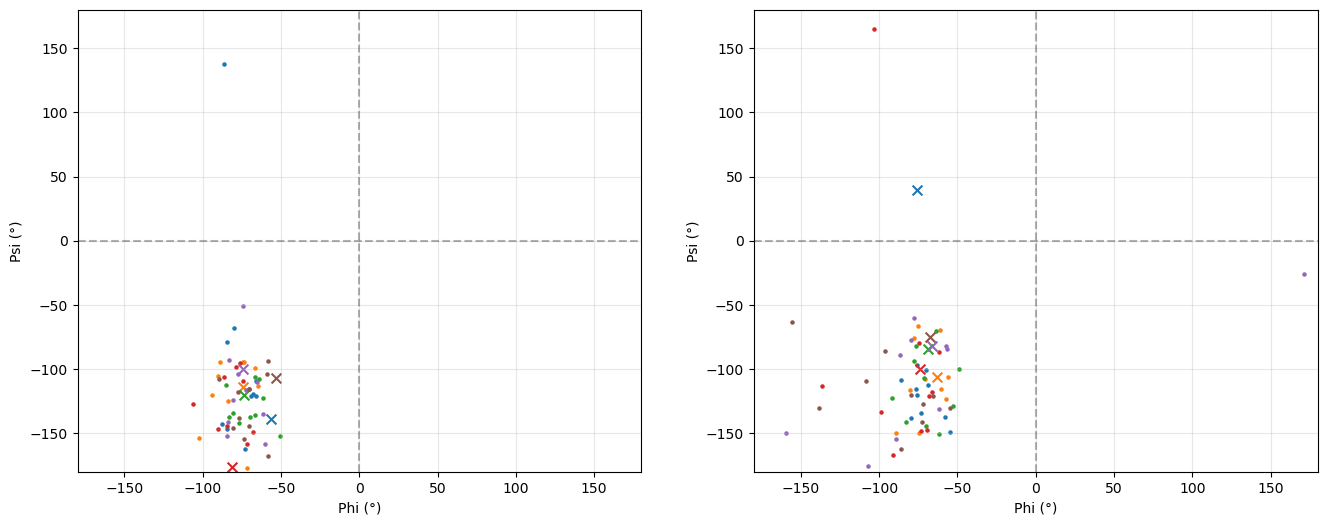

In [40]:
fig = plt.figure(figsize=(16, 6))
gs = gridspec.GridSpec(1, 2, figure=fig)
axs = [fig.add_subplot(gs[0]), fig.add_subplot(gs[1])]
for cid in range(len(test_spec)):
    axs[0].scatter(bond1[0][cid], bond1[1][cid], alpha=1, s=50, marker="x", color=f"C{cid}")
    axs[0].scatter(conformer_torsion_angles[cid][0][0], conformer_torsion_angles[cid][0][1], alpha=1, s=20, marker=".", color=f"C{cid}")
for cid in range(len(test_spec)):
    axs[1].scatter(bond2[0][cid], bond2[1][cid], alpha=1, s=50, marker="x", color=f"C{cid}")
    axs[1].scatter(conformer_torsion_angles[cid][1][0], conformer_torsion_angles[cid][1][1], alpha=1, s=20, marker=".", color=f"C{cid}")

for i in range(2):
    axs[i].set_xlim(-180, 180)
    axs[i].set_ylim(-180, 180)
    axs[i].set_xlabel('Phi (°)')
    axs[i].set_ylabel('Psi (°)')
    # ax.set_title(f'Ramachandran Plot for {(mode + " ") if mode else ""}{disaccharide} angles{(" in " + split) if split else ""} {conf} conformers')
    # Add grid lines
    axs[i].grid(alpha=0.3)
    # Add the origin lines
    axs[i].axhline(y=0, color='k', linestyle='--', alpha=0.3)
    axs[i].axvline(x=0, color='k', linestyle='--', alpha=0.3)